In [1]:
#importing python libs

import sympy as sym
sym.init_printing()

import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate
import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

%load_ext cython
import time

In [2]:
#define some s pre/post operators

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

In [26]:
delo,delm=sym.symbols('delta_o delta_mu', real=True) #detunings between input and cavity
delta3,delta2=sym.symbols('delta_3 delta_2', real=True)

delao, delam =sym.symbols('delta_a_o delta_a_mu') #detunings between atom and cavity
gamma13,gamma23,gamma2d,gamma3d,nbath,gamma12=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_12', real=True, negative=False) #energy decay for atom levels
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33') #Density matrix elements
a, b = sym.symbols('a b') #classical amplitudes of the optical and microwave fields
#ar,ai=sym.symbols('a_r a_i', real=True)
go, gm=sym.symbols('g_o, g_mu',real=True, negative=False) #coupling strengths for optical and microwave fields
Omega=sym.symbols('Omega', real=True) #pump Rabi frequency
lam=sym.symbols('lambda')

In [860]:
H_sys=Omega*s21+gm*s32*b+go*s31*a
H_sys=H_sys+Dagger(H_sys)
H_sys=H_sys+(delao -delo)*s33+(delam-delm)*s22
H_sys

⎡                        _   ⎤
⎢ 0         Ω         gₒ⋅a   ⎥
⎢                            ⎥
⎢                         _  ⎥
⎢ Ω    δₐ ₘᵤ - δₘᵤ    gₘᵤ⋅b  ⎥
⎢                            ⎥
⎣a⋅gₒ     b⋅gₘᵤ     δₐ ₒ - δₒ⎦

In [28]:
LH=-I*spre(H_sys)+I*spost(H_sys)
L32 = gamma23*(nbath+1)*collapse(s23)
L23 = gamma23*nbath*collapse(s32)
L21 = gamma12*collapse(s12)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L=LH + L21 + L23 + L32 + L31 + L22 + L33

L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
L.row_del(1)

#define the density matrix in square and row form
#the row form is so the Liovillian in matrix form can be acted on it
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]

In [29]:
L

⎡   1                        0                                           0    
⎢                                                                             
⎢           γ₁₂   γ₂₃⋅n_b   γ_2d                                             _
⎢ -ⅈ⋅Ω    - ─── - ─────── - ──── - ⅈ⋅(δₐ ₘᵤ - δₘᵤ)                    -ⅈ⋅gₘᵤ⋅b
⎢            2       2       2                                                
⎢                                                                             
⎢                                                     γ₁₃   γ₂₃⋅(n_b + 1)   γ_
⎢-ⅈ⋅a⋅gₒ                  -ⅈ⋅b⋅gₘᵤ                  - ─── - ───────────── - ──
⎢                                                      2          2          2
⎢                                                                             
⎢                                                                             
⎢  ⅈ⋅Ω                       0                                           0    
⎢                                                   

In [30]:
#change of variables to make things real to make it a bit faster maybe
CtoR = Matrix([[2,0,0,0,0,0,0,0,0],
               [0,0,0,0,2,0,0,0,0],
               [0,0,0,0,0,0,0,0,2],
               [0,1,0,1,0,0,0,0,0],
               [0,I,0,-I,0,0,0,0,0],
               [0,0,1,0,0,0,1,0,0],
               [0,0,I,0,0,0,-I,0,0],
               [0,0,0,0,0,1,0,1,0],
               [0,0,0,0,0,I,0,-I,0]
              ])
CtoR=CtoR/2

In [31]:
Lreal = sym.simplify(CtoR*L*CtoR.inv())
#ar,ai,br,bi,gmr,gmi,gor,goi=sym.symbols('a_r a_i b_r b_i g_mu_r g_mu_i g_o_r g_o_i')
#agor,agoi, bgmr, bgmi,Wr,Wi=sym.symbols('ag_or ag_oi bg_mu_r bg_mu_i Omega_r Omega_i')
ar,ai,br,bi=sym.symbols('a_r a_i b_r b_i ')
#Lreal.subs({agor:(a*go+sym.conjugate(a)*sym.conjugate(go))/2,I*(sym.conjugate(a)*sym.conjugate(go)-a*go)/2:agoi})
#Lreal1=Lreal.subs({(a+sym.conjugate(a)):2*ar,(sym.conjugate(a)-a):2*I*ai,(b+sym.conjugate(b)):2*br,(sym.conjugate(b)-b):2*I*bi})
#Lreal = Lreal.subs(a,ar+I*ai)
Lreal=Lreal.subs({sym.conjugate(a):ar-I*ai,sym.conjugate(b):br-I*bi})
Lreal=Lreal.subs({a:ar+I*ai,b:br+I*bi})
Lreal
Lrealfunc = sym.lambdify((ar,ai,br,bi,delo, delm,delao, delam, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),Lreal)


In [32]:
Lreal

⎡  1          1                  1                      0                     
⎢                                                                             
⎢  0    -γ₁₂ - γ₂₃⋅n_b     γ₂₃⋅(n_b + 1)                0                     
⎢                                                                             
⎢  0       γ₂₃⋅n_b      -γ₁₃ - γ₂₃⋅(n_b + 1)            0                     
⎢                                                                             
⎢                                               γ₁₂   γ₂₃⋅n_b   γ_2d          
⎢  0          0                  0            - ─── - ─────── - ────       -δₐ
⎢                                                2       2       2            
⎢                                                                             
⎢                                                                       γ₁₂   
⎢  Ω          -Ω                 0                 δₐ ₘᵤ - δₘᵤ        - ─── - 
⎢                                                   

In [33]:
for ii in range(81):
    #if Lreal[ii]!=0:
    print('    ' +'Lreal[' +str(ii)+ '] =' +str(Lreal.T[ii]))

    Lreal[0] =1
    Lreal[1] =0
    Lreal[2] =0
    Lreal[3] =0
    Lreal[4] =Omega
    Lreal[5] =a_i*g_o
    Lreal[6] =a_r*g_o
    Lreal[7] =0
    Lreal[8] =0
    Lreal[9] =1
    Lreal[10] =-gamma_12 - gamma_23*n_b
    Lreal[11] =gamma_23*n_b
    Lreal[12] =0
    Lreal[13] =-Omega
    Lreal[14] =0
    Lreal[15] =0
    Lreal[16] =b_i*g_mu
    Lreal[17] =b_r*g_mu
    Lreal[18] =1
    Lreal[19] =gamma_23*(n_b + 1)
    Lreal[20] =-gamma_13 - gamma_23*(n_b + 1)
    Lreal[21] =0
    Lreal[22] =0
    Lreal[23] =-a_i*g_o
    Lreal[24] =-a_r*g_o
    Lreal[25] =-b_i*g_mu
    Lreal[26] =-b_r*g_mu
    Lreal[27] =0
    Lreal[28] =0
    Lreal[29] =0
    Lreal[30] =-gamma_12/2 - gamma_23*n_b/2 - gamma_2d/2
    Lreal[31] =delta_a_mu - delta_mu
    Lreal[32] =b_i*g_mu
    Lreal[33] =b_r*g_mu
    Lreal[34] =a_i*g_o
    Lreal[35] =a_r*g_o
    Lreal[36] =0
    Lreal[37] =2*Omega
    Lreal[38] =0
    Lreal[39] =-delta_a_mu + delta_mu
    Lreal[40] =-gamma_12/2 - gamma_23*n_b/2 - gamma_2d/2
    Lreal[41] =

In [35]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose --force
#### %%cython -a # this gives "highligted" output

#cython: boundscheck=False, wraparound=False, nonecheck=False
cimport cython
import numpy as np
from cython.parallel cimport prange
cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp, sqrt
import scipy.special#.roots_legendre

#cdef double complex steady_rhoc1[3](double a_r):
#    cdef int aa = 2
#    cdef double bb[3]
#    bb[2]=a_r*aa
#    return bb
#hh=steady_rhoc1(1.9)    
#print('  ' +str(hh))
#def Lfuncflat(aval, bval,deloval,delmval, delaoval,delamval,p):
#    return Lfunc(aval, bval,deloval,delmval, delaoval,delamval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm']).T.flatten()

def steady_rho_single_c(double delta_a_o, double delta_a_mu, double complex aval,double complex bval,double delta_o,double delta_mu,p):

    cdef double Lreal[81]
    cdef double V[9]
    cdef int workspacec[9]
    cdef int info
    cdef int lda = 9
    cdef int ldb = 9 
    cdef int nrhs = 1
    cdef int n = 9
    #here I am defining the detunings using values for the ground state system
    #THIS IS NOT HOW THE FULL CODE SHOULD WORK
    cdef double gamma_13 = p['gamma13']
    cdef double gamma_23 = p['gammamu'] 
    cdef double gamma_2d = p['gamma2d']
    cdef double gamma_3d = p['gamma3d']
    cdef double n_b = p['nbath']
    cdef double gamma_12 = p['gamma23']
    cdef double g_mu = p['gm']
    cdef double g_o = p['go']
    cdef double Omega = p['Omega']
    cdef double a_r=aval.real
    cdef double a_i=aval.imag
    cdef double b_r=bval.real
    cdef double b_i=bval.imag
    V[:]=[1,0,0, 0,0,0, 0,0,0]
    
    Lreal[0] =1
    Lreal[1] =0
    Lreal[2] =0
    Lreal[3] =0
    Lreal[4] =Omega
    Lreal[5] =a_i*g_o
    Lreal[6] =a_r*g_o
    Lreal[7] =0
    Lreal[8] =0
    Lreal[9] =1
    Lreal[10] =-gamma_12 - gamma_23*n_b
    Lreal[11] =gamma_23*n_b
    Lreal[12] =0
    Lreal[13] =-Omega
    Lreal[14] =0
    Lreal[15] =0
    Lreal[16] =b_i*g_mu
    Lreal[17] =b_r*g_mu
    Lreal[18] =1
    Lreal[19] =gamma_23*(n_b + 1)
    Lreal[20] =-gamma_13 - gamma_23*(n_b + 1)
    Lreal[21] =0
    Lreal[22] =0
    Lreal[23] =-a_i*g_o
    Lreal[24] =-a_r*g_o
    Lreal[25] =-b_i*g_mu
    Lreal[26] =-b_r*g_mu
    Lreal[27] =0
    Lreal[28] =0
    Lreal[29] =0
    Lreal[30] =-gamma_12/2 - gamma_23*n_b/2 - gamma_2d/2
    Lreal[31] =delta_a_mu - delta_mu
    Lreal[32] =b_i*g_mu
    Lreal[33] =b_r*g_mu
    Lreal[34] =a_i*g_o
    Lreal[35] =a_r*g_o
    Lreal[36] =0
    Lreal[37] =2*Omega
    Lreal[38] =0
    Lreal[39] =-delta_a_mu + delta_mu
    Lreal[40] =-gamma_12/2 - gamma_23*n_b/2 - gamma_2d/2
    Lreal[41] =-b_r*g_mu
    Lreal[42] =b_i*g_mu
    Lreal[43] =a_r*g_o
    Lreal[44] =-a_i*g_o
    Lreal[45] =0
    Lreal[46] =0
    Lreal[47] =2*a_i*g_o
    Lreal[48] =-b_i*g_mu
    Lreal[49] =b_r*g_mu
    Lreal[50] =-gamma_13/2 - gamma_23*(n_b + 1)/2 - gamma_3d/2
    Lreal[51] =delta_a_o - delta_o
    Lreal[52] =0
    Lreal[53] =-Omega
    Lreal[54] =0
    Lreal[55] =0
    Lreal[56] =2*a_r*g_o
    Lreal[57] =-b_r*g_mu
    Lreal[58] =-b_i*g_mu
    Lreal[59] =-delta_a_o + delta_o
    Lreal[60] =-gamma_13/2 - gamma_23*(n_b + 1)/2 - gamma_3d/2
    Lreal[61] =Omega
    Lreal[62] =0
    Lreal[63] =0
    Lreal[64] =-2*b_i*g_mu
    Lreal[65] =2*b_i*g_mu
    Lreal[66] =-a_i*g_o
    Lreal[67] =-a_r*g_o
    Lreal[68] =0
    Lreal[69] =-Omega
    Lreal[70] =-gamma_12/2 - gamma_13/2 - gamma_23*n_b - gamma_23/2 - gamma_2d/2 - gamma_3d/2
    Lreal[71] =-delta_a_mu + delta_a_o + delta_mu - delta_o
    Lreal[72] =0
    Lreal[73] =-2*b_r*g_mu
    Lreal[74] =2*b_r*g_mu
    Lreal[75] =-a_r*g_o
    Lreal[76] =a_i*g_o
    Lreal[77] =Omega
    Lreal[78] =0
    Lreal[79] =delta_a_mu - delta_a_o - delta_mu + delta_o
    Lreal[80] =-gamma_12/2 - gamma_13/2 - gamma_23*n_b - gamma_23/2 - gamma_2d/2 - gamma_3d/2
    
    #rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    lapack.dgesv(&n,&nrhs,Lreal,&lda,workspacec,V,&ldb, &info)
    #lapack.dgesv(&n,&nrhs,L,&lda,workspace,V,&ldb,&info)
    return V
    #return [V[3]+1j*V[4],V[5]+1j*V[6]]
    #return np.array([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V[2]]])


[1/1] Cythonizing /home/peter/.cache/ipython/cython/_cython_magic_416cb69c4eef16849a68176be315efd9.pyx
building '_cython_magic_416cb69c4eef16849a68176be315efd9' extension
gcc -pthread -B /home/peter/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/peter/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/home/peter/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/home/peter/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/home/peter/anaconda3/include/python3.6m -c /home/peter/.cache/ipython/cython/_cython_magic_416cb69c4eef16849a68176be315efd9.c -o /home/peter/.cache/ipython/cython/home/peter/.cache/ipython/cython/_cython_magic_416cb69c4eef16849a68176be315efd9.o -fopenmp
gcc -pthread -shared -B /home/peter/anaconda3/compiler_compat -L/home/peter/anaconda3/lib -Wl,-rpath=/home/peter/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/peter/.cache/ipython/cython/home/peter/.cache/ipyt

In [781]:
import scipy.special
from math import pi
import math
#==============================================
#define simulation parameters
filename='output_calcs/three_lvl_test1'
deltamacvals=np.linspace(-1000e6,1000e6,2)
deltamvals=np.linspace(-600e6,600e6,1)
deltaoval=1e7
binval=50
p = {}


p['deltamu'] = 0.
p['deltao'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 0.2
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['go'] = 51.9  #optical coupling

p['No'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
#p['df']=0.1e6 # how small descretisation step to take when integrating over the
            # inhomogeneous lines

p['mean_delam']=0
p['sd_delam']=2*pi*2e6  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*1000e6 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nm'] = 2.22e18  #toal number of atoms
p['gm'] = 1.04#*0.01 #coupling between atoms and microwave field

p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
p['gammamc']=2*pi*0.0622e6
p['gammami']=2*pi*5.69e6


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqmu'] = 5.186e9
p['freq_pump'] = 195113.36e9 #pump frequency
p['freqo']=p['freqmu']+p['freq_pump']

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76
p['Omega']=-492090.88755145477


In [782]:
p

{'deltamu': 0.0,
 'deltao': 0.0,
 'd13': 1.1547005383792515e-32,
 'd23': 1.6329931618554522e-32,
 'gamma13': 30.303030303030297,
 'gamma23': 60.606060606060616,
 'gamma2d': 1000000.0,
 'gamma3d': 1000000.0,
 'nbath': 0.2,
 'gammamu': 833.3333333333334,
 'go': 51.9,
 'No': 1280000000000000.0,
 'deltac': 0,
 'kappaoi': 49951323.19207771,
 'kappaoc': 10681415.022205297,
 'mean_delam': 0,
 'sd_delam': 12566370.614359172,
 'mean_delao': 0,
 'sd_delao': 6283185307.179586,
 'kappami': 4084070.449666731,
 'kappamc': 439822.971502571,
 'Nm': 2.22e+18,
 'gm': 1.04,
 'gammaoc': 10681415.022205297,
 'gammaoi': 49951323.19207771,
 'gammamc': 390814.12610657024,
 'gammami': 35751324.39785185,
 'mu12': 4.06229459767182e-23,
 'Lsample': 0.012,
 'dsample': 0.005,
 'fillfactor': 0.8,
 'freqmu': 5186000000.0,
 'freq_pump': 195113360000000.0,
 'freqo': 195118546000000.0,
 'Lcavity_vac': 0.0495,
 'Wcavity': 0.0006,
 'nYSO': 1.76,
 'Omega': -492090.88755145477}

In [783]:
p['sd_delao']*1e-9

In [818]:
delaovals=np.linspace(-2e8,2e8,201)
delamvals=np.linspace(-2e8,2e8,201)
aval=0#1j*1000
bval=1e6#0*p['gammamc']
deloval=1e8
delmval=1e8
Temp=100e-3
#p['sd_delao']=1e10
#p['Omega']=-492090.88755145477
#p['gamma3d']=1e6
#p['gamma2d']=1e6
#p['gammamu']=883
#p['gamma13']=30
#p['gamma23']=60
gauss_fun=lambda delaoval, delamval, mo,mm,sdo,sdm: 1.0/(2*pi*sdo*sdm)*np.exp(-(delaoval-mo)**2/(2*sdo**2)
                                                                  -(delamval-mm)**2/(2*sdm**2))
rhoout=np.zeros((3,3,len(delaovals),len(delamvals)),dtype=np.complex_)
rhooutc=np.zeros((3,3,len(delaovals),len(delamvals)),dtype=np.complex_)
#steady_rho_single_c(double delta_a_o, double delta_a_mu, double complex aval,double complex bval,double delta_o,double delta_mu,p):
for ii, delaoval in enumerate(delaovals):
    for jj, delamval in enumerate(delamvals):
        omega23=np.abs(2*pi*p['freqmu']+delaoval-delamval)
        p['nbath']=1/(np.exp(1.0545718e-34*omega23/1.38064852e-23/Temp)-1)
        gauss_val=gauss_fun(delaoval,delamval,p['mean_delao'],p['mean_delam'],p['sd_delao'],p['sd_delam'])
        V=steady_rho_single_c(delaoval,delamval,aval,bval,deloval,delmval,p)
        rhooutc[:,:,ii,jj]=np.array([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V[2]]])#*gauss_val

In [819]:
p['mean_delao'],p['mean_delam'],p['sd_delao'],p['sd_delam']

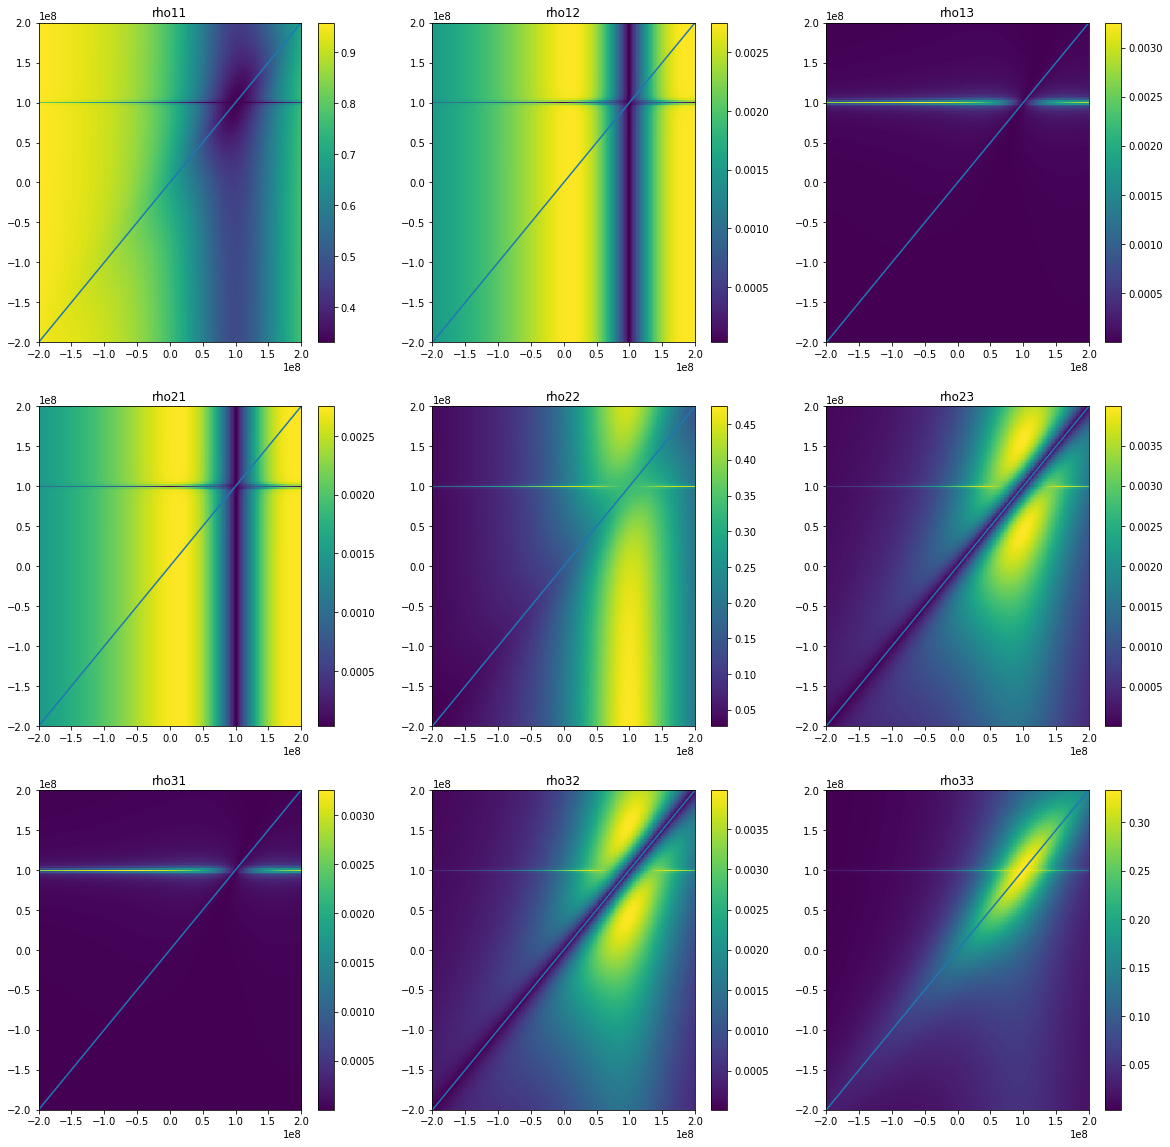

In [820]:
fig=plt.subplots(figsize=(20,20))
pltnum=1
for ii in range(3):
    for jj in range(3):
        sbplt=plt.subplot(3,3,pltnum)
        pltnum+=1
        img=sbplt.imshow(np.abs(rhooutc[ii,jj,:,:]),extent=(np.min(delamvals),np.max(delamvals),np.min(delaovals),np.max(delaovals)),aspect='auto',origin='lower')
        plt.title('rho'+str(ii+1) +str(jj+1))
        plt.plot(delaovals,delaovals)
        plt.colorbar(img)

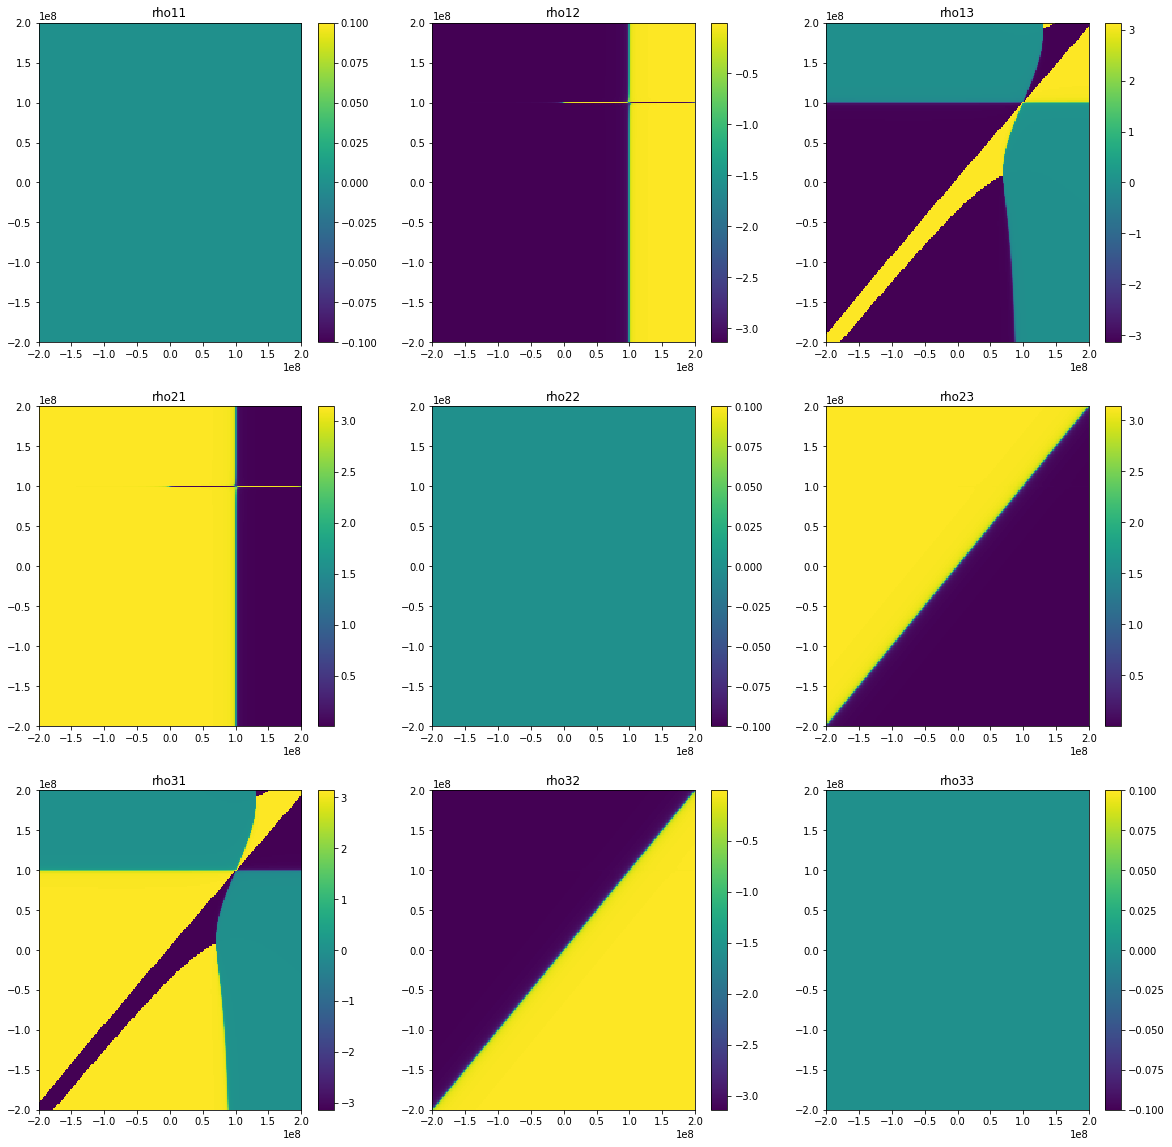

In [817]:
fig=plt.subplots(figsize=(20,20))
pltnum=1
for ii in range(3):
    for jj in range(3):
        sbplt=plt.subplot(3,3,pltnum)
        pltnum+=1
        img=sbplt.imshow(np.angle(rhooutc[ii,jj,:,:]),extent=(np.min(delamvals),np.max(delamvals),np.min(delaovals),np.max(delaovals)),aspect='auto',origin='lower')
        plt.title('rho'+str(ii+1) +str(jj+1))
        plt.colorbar(img)

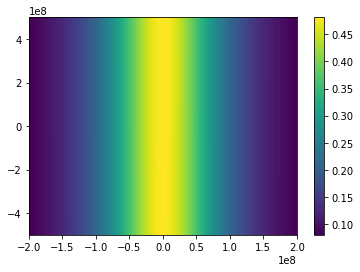

In [532]:
nn=2
plt.imshow(np.abs(rhooutc[1,1,:,:]),extent=(np.min(delamvals),np.max(delamvals),np.min(delaovals),np.max(delaovals)),aspect='auto',origin='lower')
plt.colorbar()

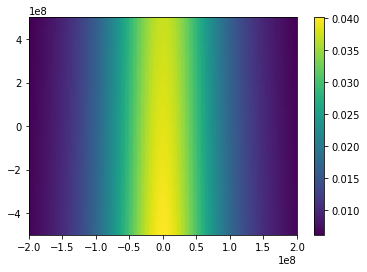

In [533]:
nn=2
plt.imshow(np.abs(rhooutc[2,2,:,:]),extent=(np.min(delamvals),np.max(delamvals),np.min(delaovals),np.max(delaovals)),aspect='auto',origin='lower')
plt.colorbar()

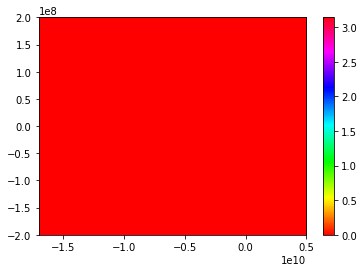

In [520]:
nn=2
plt.imshow(np.angle(rhooutc[1,2,:,:]),extent=(np.min(delaovals),np.max(delaovals),np.min(delamvals),np.max(delamvals)),aspect='auto',origin='lower',cmap='hsv')
plt.colorbar()

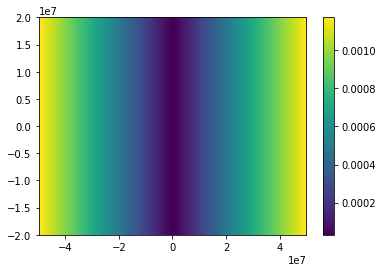

In [293]:
nn=2
plt.imshow(np.abs(rhooutc[1,0,:,:]),extent=(np.min(delaovals),np.max(delaovals),np.min(delamvals),np.max(delamvals)),aspect='auto',origin='lower')
plt.colorbar()

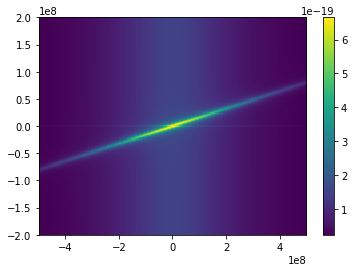

In [439]:
nn=2
plt.imshow(np.abs(rhooutc[2,2,:,:]),extent=(np.min(delaovals),np.max(delaovals),np.min(delamvals),np.max(delamvals)),aspect='auto',origin='lower')
plt.colorbar()

In [821]:
from c_funs_excited import rho_broad_full

In [851]:


deltamvals=np.linspace(0.8,1.2e8,1)
deltamacvals=np.linspace(0,2e8,400)
rhoc1=np.zeros((3,3,len(deltamacvals),len(deltamvals)),dtype=np.complex_)
bval=1
for ii,deltamacval in enumerate(deltamacvals):
    p['mean_delam']=deltamacval
    for jj, deltamval in enumerate(deltamvals):
        rhoc1[:,:,ii,jj]=rho_broad_full(0,bval,0,deltamval,p)
        

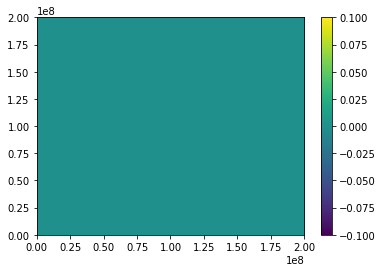

In [852]:
nn=2
plt.imshow(np.abs(rhoc[2,1,:,:]),extent=(np.min(deltamvals),np.max(delamvals),np.min(deltamacvals),np.max(deltamacvals)),aspect='auto',origin='lower')
plt.colorbar()

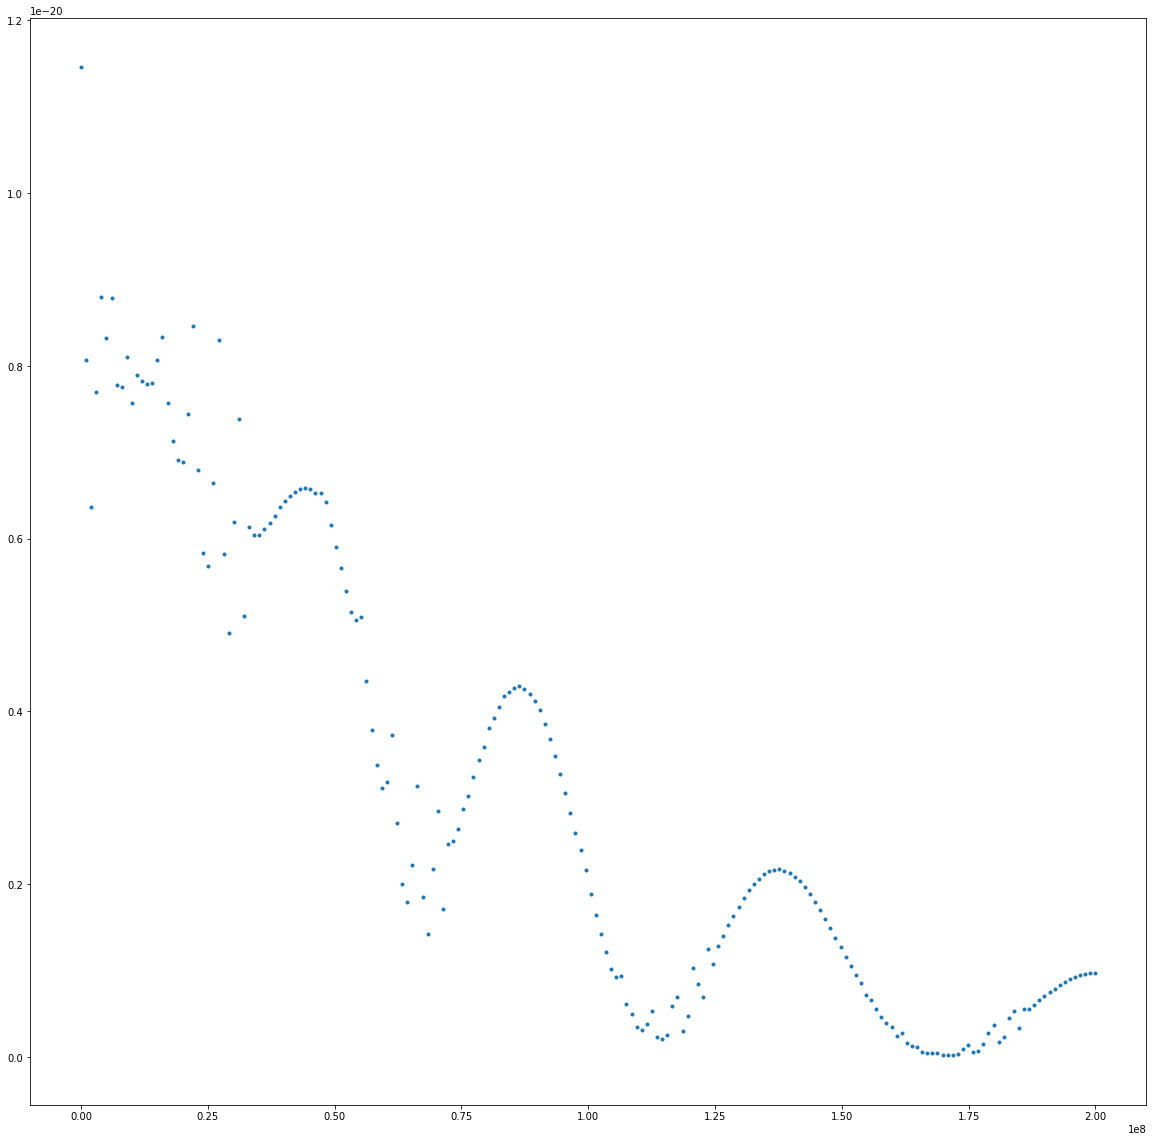

In [849]:
plt.figure(figsize=(20,20))
plt.plot(deltamacvals,np.abs(rhoc[2,1,:,0].T)**2,'.')


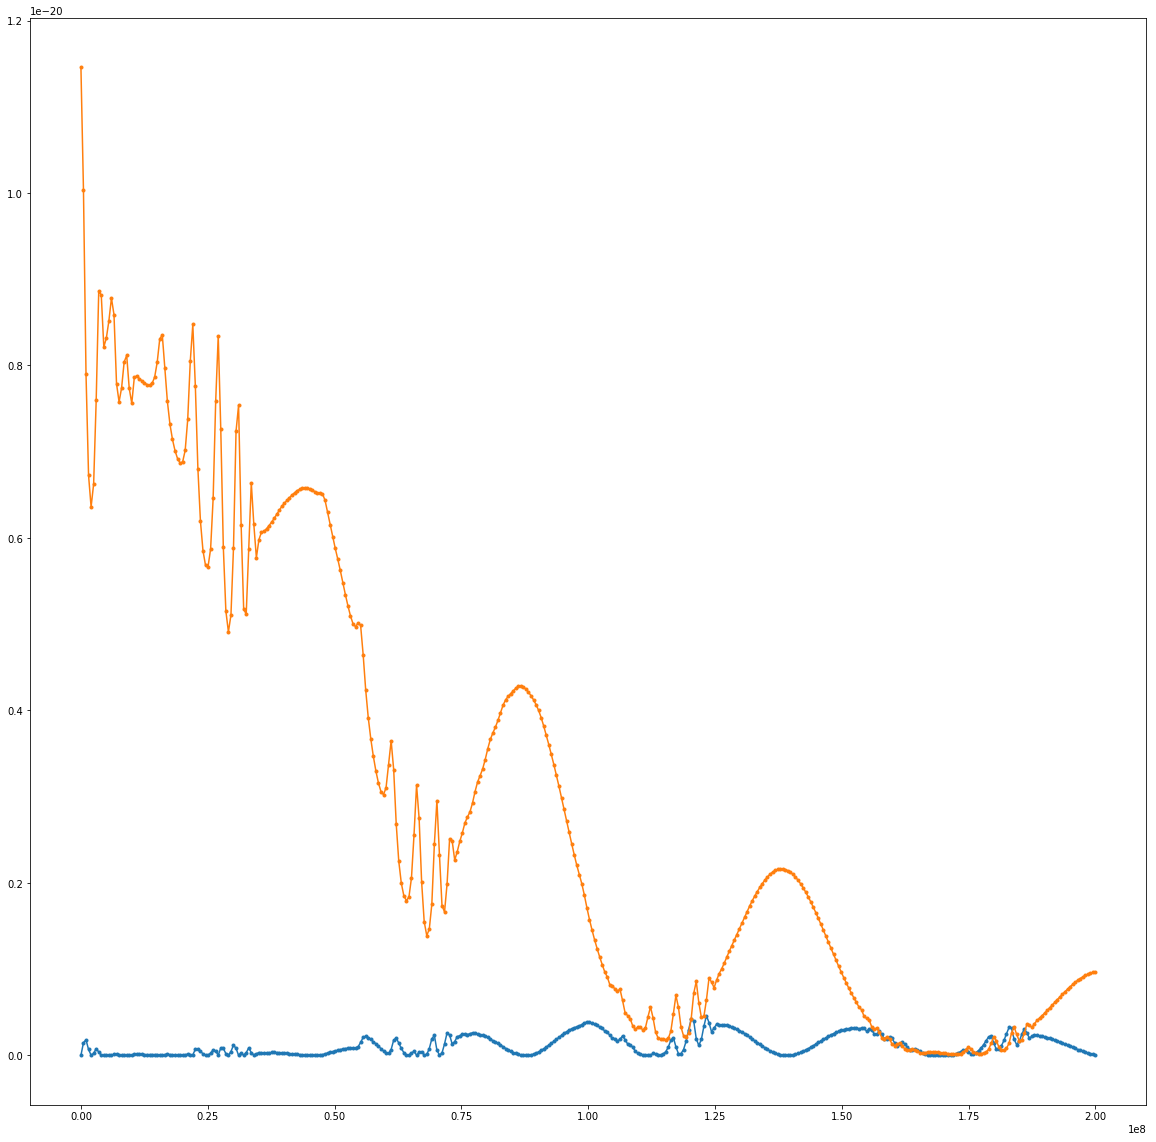

In [859]:
plt.figure(figsize=(20,20))
plt.plot(deltamacvals,np.real(rhoc1[2,1,:,0].T)**2,'.-')
plt.plot(deltamacvals,np.imag(rhoc1[2,1,:,0].T)**2,'.-')


In [839]:
deltamvals

array([0.8])